In [3]:
# Standard import(s)
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random as rn
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer


In [4]:
# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Embedding, GlobalAveragePooling1D,Conv1D,MaxPool1D,Dropout, Bidirectional ,UpSampling1D, SimpleRNN,LSTM
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [5]:

# convert phrases to numerical representation: bag of words
phrase_data = pd.read_pickle("clean_phrase_data4.pkl") 
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']

#split phrase datasets to x and y
X = phrase_data["feature"].copy()
y = phrase_data["label"].copy()


#create word vector 
vectorizer = CountVectorizer()
vectorizerfit = vectorizer.fit_transform(X.astype(str))
names = vectorizer.get_feature_names()
count_array = vectorizerfit.toarray()
vec = pd.DataFrame(data=count_array,columns=names)

x_train, x_test, y_train, y_test = train_test_split(vec, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)
shape = x_train.shape[1]
xshape = x_train.shape[0]

(106412, 17719) (45606, 17719) (106412,)


# Dense networks

In [126]:
###########this model overtrains - high training acc, low testing acc

inputs = Input(shape=shape)
encoded_h1 = Dense(256, activation='relu')(inputs)
encoded_h2 = Dense(128, activation='relu')(encoded_h1)
encoded_h3 = Dense(64, activation='relu')(encoded_h2)
encoded_h4 = Dense(32, activation='relu')(encoded_h3)
encoded_h5 = Dense(16, activation='relu')(encoded_h4)
output = Dense(len(labels),activation='softmax')(encoded_h5)
mdl = Model(inputs,output)

mdl.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 17719)]           0         
_________________________________________________________________
dense_62 (Dense)             (None, 256)               4536320   
_________________________________________________________________
dense_63 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 85 

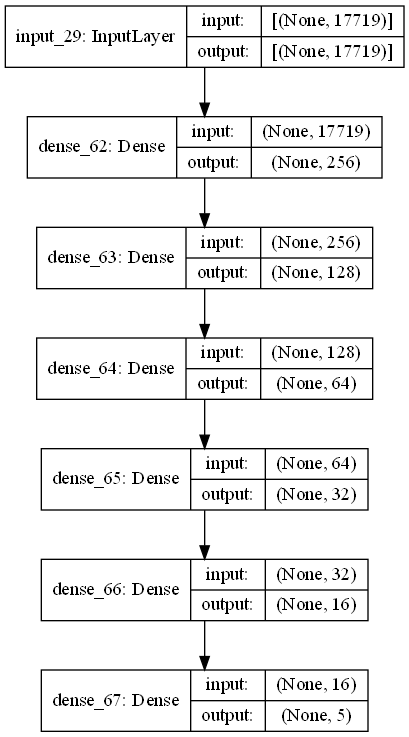

In [127]:
plot_model(mdl, show_shapes=True)

In [128]:
mdl.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

cnn = mdl.fit(x_train,y_train,epochs=20,batch_size=32, validation_split=0.2)

Train on 85129 samples, validate on 21283 samples
Epoch 1/20
85129/85129 [==============================] - 113s 1ms/sample - loss: 1.1321 - acc: 0.5233 - val_loss: 1.0407 - val_acc: 0.5516
Epoch 2/20
85129/85129 [==============================] - 96s 1ms/sample - loss: 0.9183 - acc: 0.5971 - val_loss: 1.0413 - val_acc: 0.5458ss: 0.9182 - acc: 0.
Epoch 3/20
85129/85129 [==============================] - 93s 1ms/sample - loss: 0.7895 - acc: 0.6436 - val_loss: 1.1000 - val_acc: 0.5363
Epoch 4/20
85129/85129 [==============================] - 80s 945us/sample - loss: 0.6792 - acc: 0.6852 - val_loss: 1.2127 - val_acc: 0.49596786 - ac
Epoch 5/20
85129/85129 [==============================] - 72s 842us/sample - loss: 0.5909 - acc: 0.7189 - val_loss: 1.3769 - val_acc: 0.4834
Epoch 6/20
85129/85129 [==============================] - 67s 789us/sample - loss: 0.5197 - acc: 0.7452 - val_loss: 1.5758 - val_acc: 0.4752
Epoch 7/20
85129/85129 [==============================] - 71s 832us/sample - los

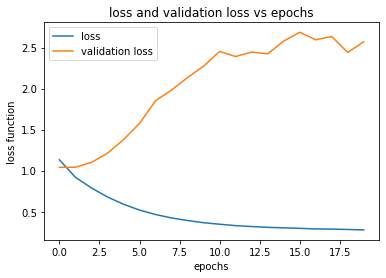

In [129]:
plt.plot(cnn.history['loss'],label="loss")
plt.plot(cnn.history['val_loss'],label="validation loss")
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [130]:
misc,testacc = mdl.evaluate(x_test,y_test)
misc,trainacc = mdl.evaluate(x_train,y_train)

print("Overall accuracy for training dataset: "+ str(trainacc*100) +"%")
print("Overall accuracy for testing dataset: "+ str(testacc*100) + "%")

106412/106412 [==============================] - 34s 318us/sample - loss: 0.7201 - acc: 0.7659
Overall accuracy for training dataset: 76.58534646034241%
Overall accuracy for testing dataset: 41.8190598487854%


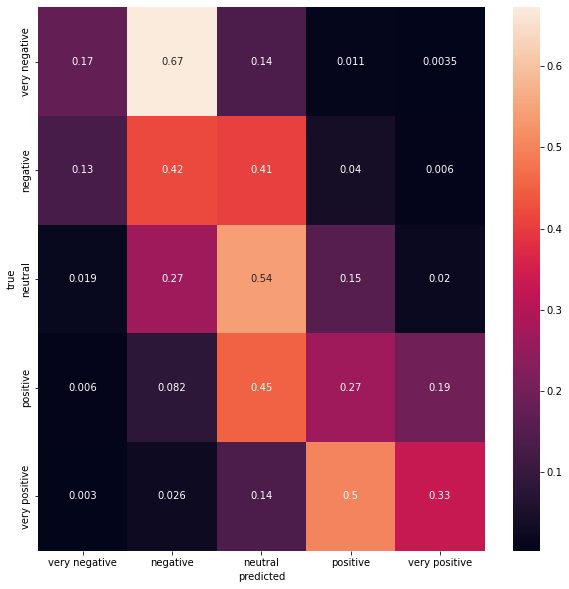

In [131]:
matrix = confusion_matrix(y_test,mdl.predict(x_test).argmax(axis=-1), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()



## same model but with regularisation, less complexity +dropout

In [132]:



inputs = Input(shape=shape)
encoded_h1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
encoded_h2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(encoded_h1)
drop = Dropout(0.25)(encoded_h2)
encoded_h3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop)
drop = Dropout(0.25)(encoded_h3)
encoded_h4 = Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(drop)
drop = Dropout(0.25)(encoded_h4)
output = Dense(len(labels),activation='softmax')(drop)
dense_sparse = Model(inputs,output)

dense_sparse.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 17719)]           0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               2268160   
_________________________________________________________________
dense_69 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 16)                528

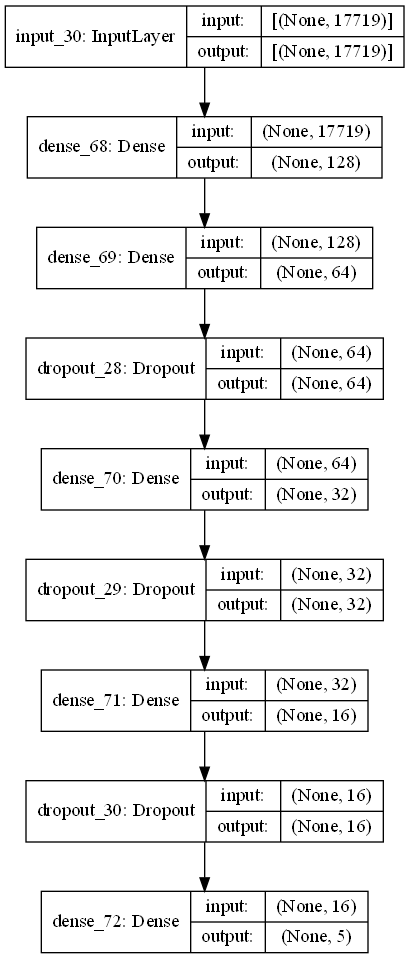

In [133]:
plot_model(dense_sparse, show_shapes=True)

In [134]:
dense_sparse.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

dense_s = dense_sparse.fit(x_train,y_train,epochs=20,batch_size=32, validation_split=0.2)

Train on 85129 samples, validate on 21283 samples
Epoch 1/20
85129/85129 [==============================] - 69s 812us/sample - loss: 1.3792 - acc: 0.4978 - val_loss: 1.2810 - val_acc: 0.5367
Epoch 2/20
85129/85129 [==============================] - 65s 763us/sample - loss: 1.2544 - acc: 0.5439 - val_loss: 1.2198 - val_acc: 0.5484
Epoch 3/20
85129/85129 [==============================] - 66s 773us/sample - loss: 1.1695 - acc: 0.5632 - val_loss: 1.1828 - val_acc: 0.5491
Epoch 4/20
85129/85129 [==============================] - 67s 791us/sample - loss: 1.1138 - acc: 0.5785 - val_loss: 1.1654 - val_acc: 0.5486
Epoch 5/20
85129/85129 [==============================] - 67s 791us/sample - loss: 1.0797 - acc: 0.5854 - val_loss: 1.1732 - val_acc: 0.5475
Epoch 6/20
85129/85129 [==============================] - 67s 785us/sample - loss: 1.0578 - acc: 0.5939 - val_loss: 1.1753 - val_acc: 0.5476
Epoch 7/20
85129/85129 [==============================] - 67s 793us/sample - loss: 1.0404 - acc: 0.5989 

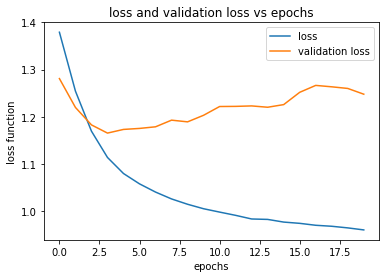

In [138]:
plt.plot(dense_s.history['loss'],label="loss")
plt.plot(dense_s.history['val_loss'],label="validation loss")
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [139]:
misc,testacc = dense_sparse.evaluate(x_test,y_test)
misc,trainacc = dense_sparse.evaluate(x_train,y_train)

print("Overall accuracy for training dataset: "+ str(trainacc*100) +"%")
print("Overall accuracy for testing dataset: "+ str(testacc*100) + "%")

106412/106412 [==============================] - 35s 330us/sample - loss: 0.9427 - acc: 0.6469
Overall accuracy for training dataset: 64.68913555145264%
Overall accuracy for testing dataset: 52.21242904663086%


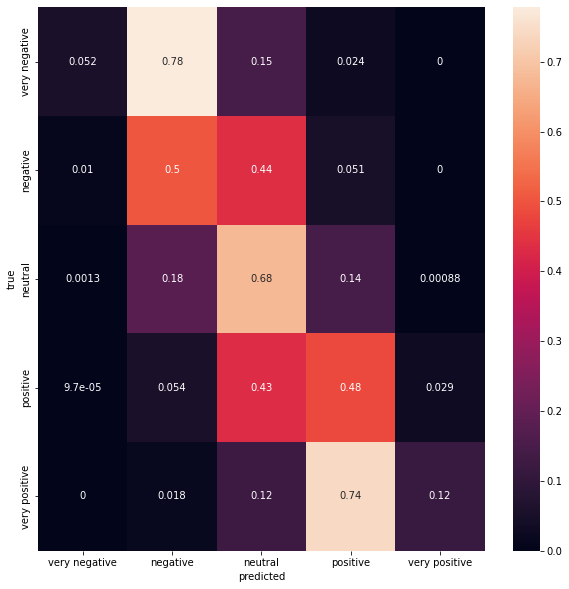

In [140]:
matrix = confusion_matrix(y_test,dense_sparse.predict(x_test).argmax(axis=-1), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

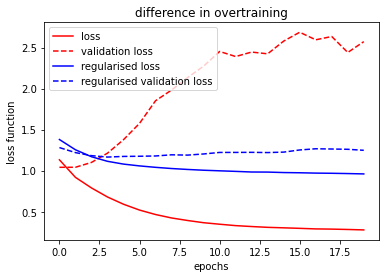

In [148]:
plt.plot(cnn.history['loss'], label="loss", color = 'red')
plt.plot(cnn.history['val_loss'],'--',label="validation loss", color = 'red')
plt.plot(dense_s.history['loss'],label="regularised loss", color = 'blue')
plt.plot(dense_s.history['val_loss'],'--',label="regularised validation loss",color = 'blue')
plt.title('difference in overtraining')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()
np.savetxt("losshist.txt",dense_s.history['loss'])
np.savetxt("vallosshist.txt",dense_s.history['val_loss'])

In [11]:
# 1D CNN

x_train = x_train.to_numpy()
x_test= x_test.to_numpy()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1 ).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], 1).astype('float32') 

In [12]:
# 1D CNN
inputs = Input(shape=(shape,1))
encoded_h1 = Conv1D(50,kernel_size=3, activation='relu')(inputs)
pool1 = MaxPool1D(pool_size=2)(encoded_h1)
encoded_h2 = Conv1D(40,kernel_size=3, activation='relu')(pool1)
pool2 = MaxPool1D(pool_size=2)(encoded_h2)
encoded_h3 = Conv1D(30,kernel_size=3, activation='relu')(pool2)
pool3 = MaxPool1D(pool_size=2)(encoded_h3)
flat = Flatten()(pool3)
data = Dense(20, activation='relu')(flat)
drop = Dropout(0.5)(data)
output = Dense(len(labels),activation='softmax')(drop)
cnn_sparse = Model(inputs,output)

cnn_sparse.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17719, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17717, 50)         200       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8858, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8856, 40)          6040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4428, 40)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4426, 30)          3630      
_________

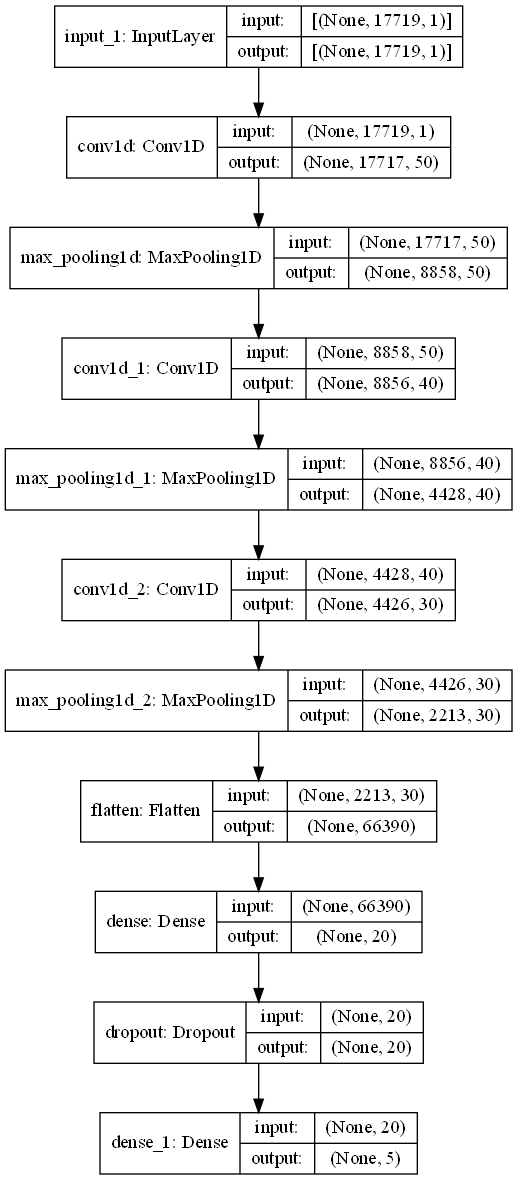

In [13]:
plot_model(cnn_sparse, show_shapes=True)

In [14]:

cnn_sparse.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

cnn_s = cnn_sparse.fit(x_train,y_train,epochs=10,batch_size=256, validation_split=0.2)

Train on 85129 samples, validate on 21283 samples
Epoch 1/10
85129/85129 [==============================] - 875s 10ms/sample - loss: 1.3217 - acc: 0.4599 - val_loss: 1.1802 - val_acc: 0.5004
Epoch 2/10
85129/85129 [==============================] - 859s 10ms/sample - loss: 1.2075 - acc: 0.4956 - val_loss: 1.1296 - val_acc: 0.5186
Epoch 3/10
85129/85129 [==============================] - 816s 10ms/sample - loss: 1.1609 - acc: 0.5065 - val_loss: 1.0939 - val_acc: 0.5273
Epoch 4/10
85129/85129 [==============================] - 808s 9ms/sample - loss: 1.1193 - acc: 0.5237 - val_loss: 1.0764 - val_acc: 0.5372
Epoch 5/10
85129/85129 [==============================] - 804s 9ms/sample - loss: 1.0876 - acc: 0.5307 - val_loss: 1.0603 - val_acc: 0.5402
Epoch 6/10
85129/85129 [==============================] - 804s 9ms/sample - loss: 1.0626 - acc: 0.5387 - val_loss: 1.0567 - val_acc: 0.5421
Epoch 7/10
85129/85129 [==============================] - 802s 9ms/sample - loss: 1.0460 - acc: 0.5414 - va

106412/106412 [==============================] - 269s 3ms/sample - loss: 0.8895 - acc: 0.5976
Overall accuracy for training dataset: 59.75735783576965%
Overall accuracy for testing dataset: 54.707711935043335%


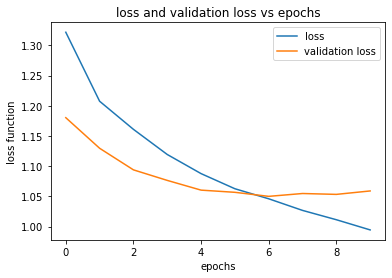

In [15]:
misc,testacc = cnn_sparse.evaluate(x_test,y_test)
misc,trainacc = cnn_sparse.evaluate(x_train,y_train)
print("Overall accuracy for training dataset: "+ str(trainacc*100) +"%")
print("Overall accuracy for testing dataset: "+ str(testacc*100) + "%")

plt.plot(cnn_s.history['loss'],label="loss")
plt.plot(cnn_s.history['val_loss'],label="validation loss")
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()



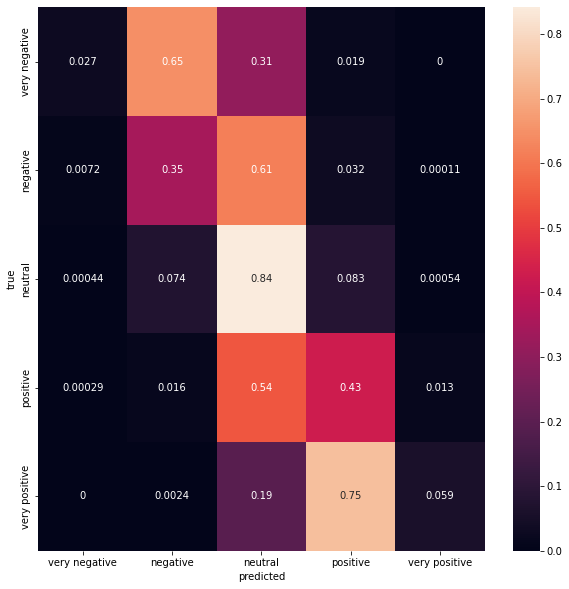

In [16]:
matrix = confusion_matrix(y_test,cnn_sparse.predict(x_test).argmax(axis=-1), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

In [17]:
lh = np.loadtxt("losshist.txt")
vh = np.loadtxt("vallosshist.txt")

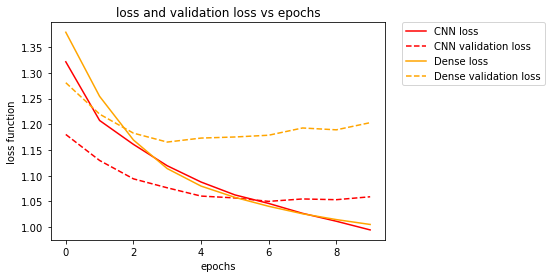

In [18]:
plt.plot(cnn_s.history['loss'], label="CNN loss", color = 'red')
plt.plot(cnn_s.history['val_loss'],'--',label="CNN validation loss", color = 'red')
plt.plot(lh[:10],label="Dense loss",color = 'orange')
plt.plot(vh[:10],'--',label="Dense validation loss",color = 'orange')
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



# Test sentences - run first 3 blocks first!!

In [81]:
sentences = pd.read_pickle("actual_sentences.txt") 
token_sentences = pd.read_pickle("clean_sentences.pkl")

In [7]:
#process in same way

token_vec = vectorizer.transform(token_sentences.astype(str))
count_array = vectorizerfit.toarray()
token_vec = pd.DataFrame(data=count_array,columns=names)


In [21]:
token_vec = token_vec.to_numpy()

token_vec = token_vec.reshape(token_vec.shape[0], token_vec.shape[1],1 ).astype('float32')

In [22]:
predicted_sentiment = cnn_sparse.predict(token_vec)


In [57]:
predicted_sentiment=predicted_sentiment[:11856]
confidence = (100*predicted_sentiment.max(axis=-1))
pred_score = (predicted_sentiment.argmax(axis=-1))

In [59]:

print(predicted_sentiment.shape)
print(sentences.shape)
print(token_sentences.shape)
print(token_vec.shape)
print(vec.shape)

(11856, 5)
(11856,)
(11856,)
(152018, 17719, 1)
(152018, 17719)


In [82]:
#print sentences with highest & lowest confidence in classification

lowestindex = np.argsort(confidence)[:15]
highestindex = (np.argsort(confidence)[::-1])[:15]
pd.options.display.max_colwidth = 100


print("lowest:")
print(pred_score[lowestindex])
print(confidence[lowestindex])
print(sentences[lowestindex])

print("highest:")
print(pred_score[highestindex])
print(confidence[highestindex])
print(sentences[highestindex])


lowest:
[2 2 1 2 1 3 3 3 3 3 3 2 3 3 2]
[27.01205  27.06285  27.26628  27.37083  27.59124  27.601646 27.601646
 27.725357 28.00151  28.00151  28.098312 28.836382 29.049715 29.049715
 29.262957]
4213               Baran is shockingly devoid of your typical Majid Majidi shoe-loving , crippled children .
6301     Instead of building to a laugh riot we are left with a handful of disparate funny moments of no ...
8627                                                            Do n't let your festive spirit go this far .
11697                                                                                  A true-blue delight .
8602                                                                     Lucy 's a dull girl , that 's all .
610                      A historical epic with the courage of its convictions about both scope and detail .
611      We need -LRB- Moore 's -RRB- noisy , cocky energy , his passion and class consciousness ; we nee...
5226                                       

(11856,)